In [7]:
import pandas as pd
import numpy as np
import torch
import tqdm
import os
import glob
import cv2
import skimage.metrics as metrics
import matplotlib.pyplot as plt
import re
import model as autoencoder
from torchvision import transforms
import matplotlib.lines as mlines

In [8]:
test_images_path = '/home/maciejka/Desktop/school/S8/labwork-project/db/dataset_preprocessed/test'
path_to_models = '/home/maciejka/Desktop/school/S8/labwork-project/models'
path_to_history = '/home/maciejka/Desktop/school/S8/labwork-project/history'

models = sorted(glob.glob(os.path.join(path_to_models,'*.pth')))
histories = sorted(glob.glob(os.path.join(path_to_history,'*.csv')))

test_gt = sorted(glob.glob(os.path.join(test_images_path,'input', '*.bmp')))
test_input = sorted(glob.glob(os.path.join(test_images_path,'output', '*.bmp')))



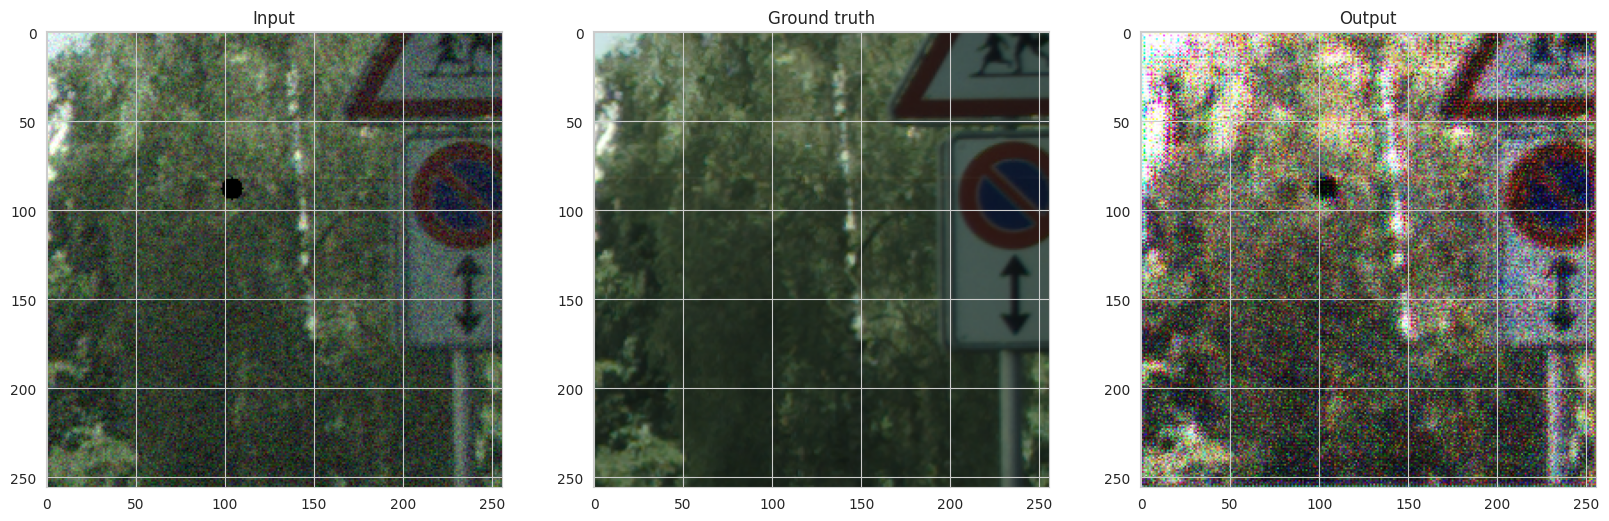

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
def get_model_infos(text, debug = False):

    loss_pattern = r'_(frequency|mse|focal)_loss'
    stacks_pattern = r'_(\d+)stacks'
    csize_pattern = r'_(\d+)Csize'
    zsize_pattern = r'_(\d+)Zsise'  # <-- change to 'Zsize' if typo

    loss = re.search(loss_pattern, text).group(1)
    stacks = re.search(stacks_pattern, text).group(1)
    csize = re.search(csize_pattern, text).group(1)
    zsize = re.search(zsize_pattern, text).group(1)

    if debug:
        print("Loss:", loss)
        print("Stacks:", stacks)
        print("Csize:", csize)
        print("Zsize:", zsize)

    return loss, stacks, csize, zsize

def get_test_data_infos(text, debug = False):

    loss_pattern = r'_(frequency|mse|focal)_loss'
    stacks_pattern = r'_(\d+)stacks'
    csize_pattern = r'_(\d+)csize'
    zsize_pattern = r'_(\d+)zsize'  # <-- change to 'Zsize' if typo

    loss = re.search(loss_pattern, text).group(1)
    stacks = re.search(stacks_pattern, text).group(1)
    csize = re.search(csize_pattern, text).group(1)
    zsize = re.search(zsize_pattern, text).group(1)

    if debug:
        print("Loss:", loss)
        print("Stacks:", stacks)
        print("Csize:", csize)
        print("Zsize:", zsize)

    return loss, stacks, csize, zsize

def load_model_and_history(loss, stacks, csize, zsize, only_history=False):
    model_regex = (os.path.join(path_to_models, f'model_*_{loss}_loss_{stacks}stacks_3colors_{csize}Csize_{zsize}Zsise.pth'))
    history_regex = (os.path.join(path_to_history, f'model_*_{loss}_loss_{stacks}stacks_3colors_{csize}Csize_{zsize}Zsise.csv'))

    model_path = glob.glob(model_regex)
    history_path = glob.glob(history_regex)
    history = pd.read_csv(*history_path)

    if not only_history:
        model = autoencoder.ChainedAutoencoder(int(stacks), 3 , int(csize), int(zsize), 'unet')
        model.load_state_dict(torch.load(*model_path, map_location=torch.device('cpu')))
        return model, history
    else:
        return history


def load_test_data(loss, stacks, csize, zsize):
    test_data_regex = (os.path.join('test_data', f'test_data_{loss}_loss_{stacks}stacks_{csize}csize_{zsize}zsize.csv'))
    test_data_path = glob.glob(test_data_regex)
    return pd.read_csv(*test_data_path)



def classify_image(model, image, gt_path, output='metrics'):
    image_numpy = cv2.imread(image, cv2.IMREAD_COLOR)
    image_numpy = cv2.cvtColor(image_numpy, cv2.COLOR_BGR2RGB)

    gt = cv2.imread(gt_path, cv2.IMREAD_COLOR)
    gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

    input_tensor = transform(image_numpy).unsqueeze(0)
    image_output = model(input_tensor)
    pred = image_output.detach().numpy()[0].transpose(1, 2, 0)

    mse = metrics.mean_squared_error(gt, pred)
    psnr = metrics.peak_signal_noise_ratio(gt, pred)

    ssim = metrics.structural_similarity(gt, pred, channel_axis=2, data_range=1)

    if output == 'metrics':
        return mse, psnr, ssim
    elif output == 'image':
        return pred
    else:
        raise ValueError("Invalid output type. Choose 'metrics' or 'image'.")


def test_image_context(model, im, gt):

    output = classify_image(model, im, gt, output='image')

    im_in = cv2.imread(im, cv2.IMREAD_COLOR)
    im_in = cv2.cvtColor(im_in, cv2.COLOR_BGR2RGB)

    gt = cv2.imread(gt, cv2.IMREAD_COLOR)
    gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))

    ax[0].imshow(im_in)
    ax[0].set_title('Input')
    ax[1].imshow(gt)
    ax[1].set_title('Ground truth')
    ax[2].imshow(output)
    ax[2].set_title('Output')

def calculate_metrics(model, test_input, test_gt):
    output_dict = {
        'img': [],
        'mse': [],
        'psnr': [],
        'ssim': [],
    }

    for in_path, gt_path in tqdm.tqdm(zip(test_input, test_gt), total=len(test_input), desc='Calculating metrics...', leave=False):
        mse, psnr, ssim = classify_image(model, in_path, gt_path, output='metrics')
        output_dict['img'].append(in_path)
        output_dict['mse'].append(mse)
        output_dict['psnr'].append(psnr)
        output_dict['ssim'].append(ssim)


    df = pd.DataFrame(output_dict)
    return df




infos = get_model_infos(models[0])
model, history = load_model_and_history('focal', 1, 64, 1024)
test_image_context(model, test_input[581], test_gt[581])


In [13]:
i = 1
for model_path in models:
    print('model {} / {}'.format(i, len(models)))
    loss, stacks, csize, zsize = get_model_infos(model_path)
    path = '/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_{}_loss_{}stacks_{}csize_{}zsize.csv'.format(loss, stacks, csize, zsize)
    print(path)
    model, history = load_model_and_history(loss, stacks, csize, zsize)
    met = calculate_metrics(model, test_input, test_gt)
    met.to_csv(path, index=False)
    i += 1

model 1 / 1
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_focal_loss_1stacks_64csize_1024zsize.csv


In [15]:
test_datas = glob.glob(os.path.join('test_data', 'test_data_*.csv'))
output_dict = {
    'loss': [],
    'stacks': [],
    'csize': [],
    'zsize': [],

    'training_time': [],
    'loss_training': [],
    'mse': [],
    'psnr': [],
    'ssim': [],

}
for test_data in test_datas:
    loss, stacks, csize, zsize = get_test_data_infos(test_data)
    df_history = load_model_and_history(loss, stacks, csize, zsize, only_history=True)

    df_test = pd.read_csv(test_data)
    print(df_history)

    output_dict['loss'].append(loss)
    output_dict['stacks'].append(stacks)
    output_dict['csize'].append(csize)
    output_dict['zsize'].append(zsize)
    output_dict['training_time'].append(df_history['time'].iloc[-1])
    output_dict['loss_training'].append(df_history['val_loss'].iloc[-1])

    #
    mse = df_test['mse'].mean()
    psnr = df_test['psnr'].mean()
    ssim = df_test['ssim'].mean()

    output_dict['mse'].append(mse)
    output_dict['psnr'].append(psnr)
    output_dict['ssim'].append(ssim)

output_df = pd.DataFrame(output_dict)

output_df


    epoch          loss       val_loss        time
0       1  1.695694e+06  353796.750000   20.338073
1       2  2.710419e+05  195317.185268   38.977739
2       3  1.997464e+05  152713.311384   58.426298
3       4  1.733004e+05  131840.632812   77.334508
4       5  1.635873e+05  120979.816964   95.667737
5       6  1.564520e+05  113674.614955  114.805034
6       7  1.480142e+05  118681.462054  133.777730
7       8  1.416795e+05  143699.648438  152.912604
8       9  1.346483e+05  170598.314732  171.258986
9      10  1.303979e+05  117066.867188  189.543067
10     11  1.171471e+05  129451.415179  208.435092
11     12  1.104812e+05  148903.321429  226.966553
12     13  1.033540e+05  233974.125000  245.926042
13     14  9.469495e+04  124295.200893  265.033384
14     15  7.794372e+04  120759.869141  284.258921
15     16  6.872790e+04  109588.412388  302.909398
16     17  5.251919e+04  182759.147321  322.173437
17     18  4.618422e+04  125387.085938  341.170879
18     19  3.768929e+04  124262

,loss,stacks,csize,zsize,training_time,loss_training,mse,psnr,ssim
0,focal,1,64,1024,852.973895,140430.28683,0.052716,13.239951,0.201436


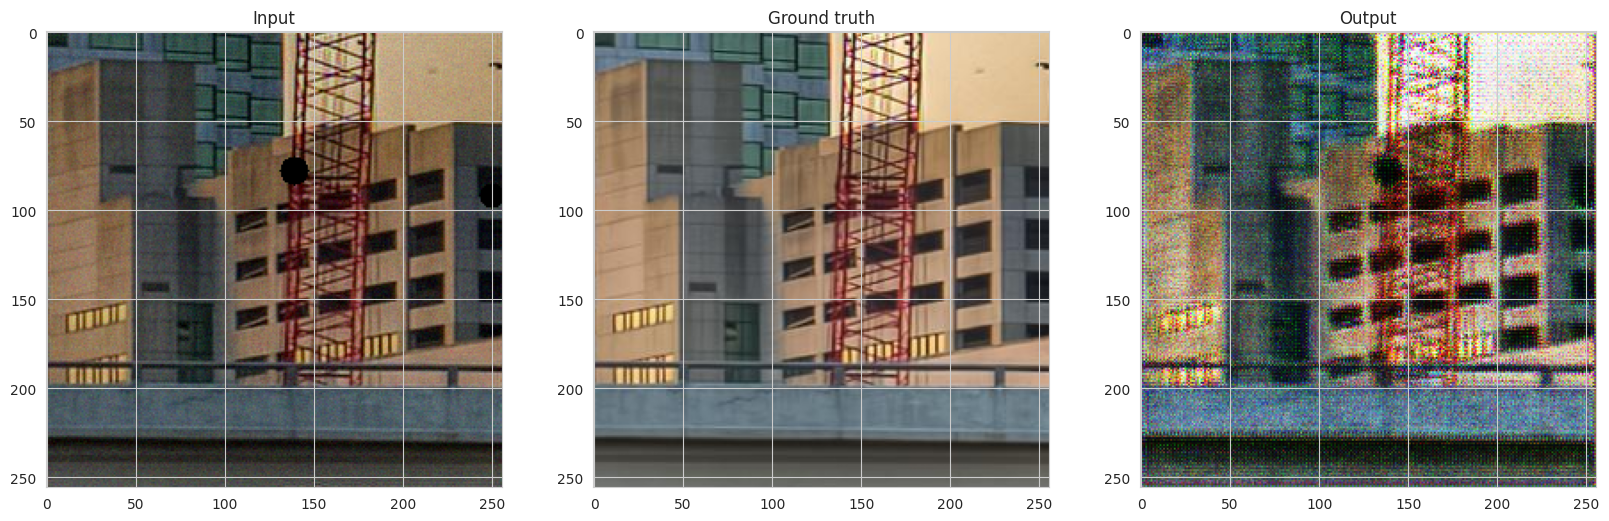

In [17]:
model, history = load_model_and_history('focal', 1, 64, 1024)
test_image_context(model, test_input[123], test_gt[123])

TypeError: ttest_rel() got an unexpected keyword argument 'equal_var'

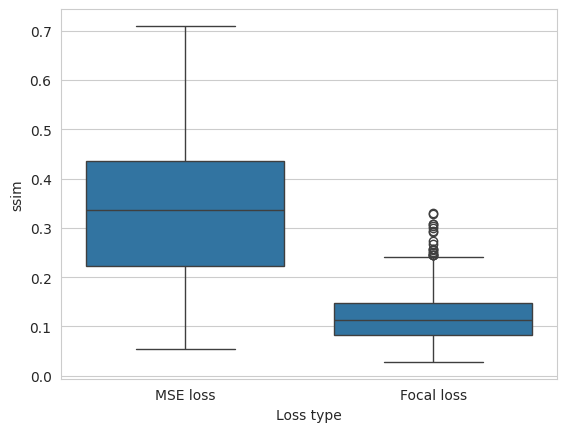

In [44]:
import seaborn as sns
from scipy import stats
# comparision - frequency vs mse
test_val = 'ssim'
data1 = ['mse', 1, 64, 256]
data2 = ['frequency', 1, 64, 256]

test_data_1 = load_test_data(*data1)
test_data_2 = load_test_data(*data2)

test_data_1['Loss type'] = 'MSE loss'
test_data_2['Loss type'] = 'Frequency loss'

df = pd.concat([test_data_1, test_data_2], ignore_index=True)

sns.boxplot(x='Loss type', y=test_val, data=df)#, split=True, inner='quartile')

t_stat, p_value = stats.ttest_rel(test_data_1[test_val], test_data_2[test_val], equal_var=False, alternative='two-sided')
print(f"t-statistic: {t_stat}, p-value: {p_value}")

df


t-statistic: 56.79658151231645, p-value: 2.934290515438157e-280


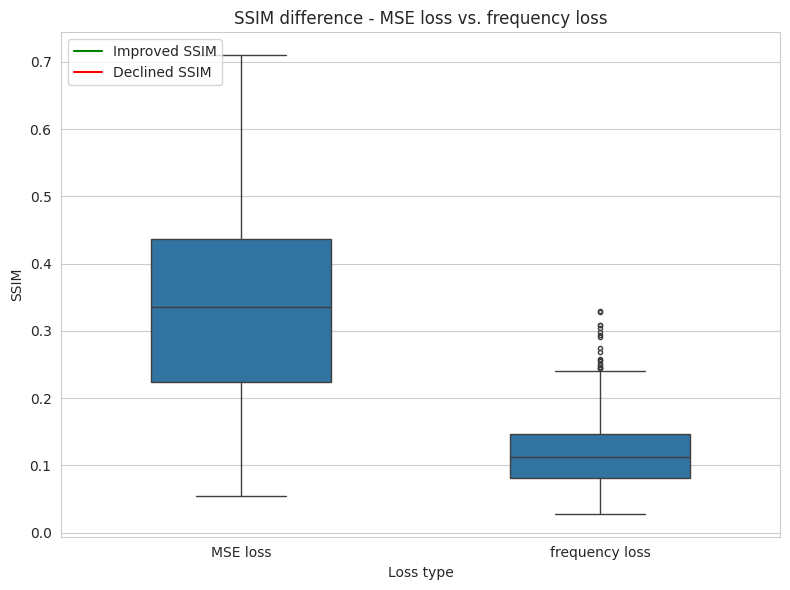

In [46]:


test_val = 'ssim'

data_1_diff = 'MSE loss'
data_2_diff = 'frequency loss'
data1 = ['mse', 1, 64, 256]
data2 = ['frequency', 1, 64, 256]

df1 = load_test_data(*data1)
df2 = load_test_data(*data2)
suffix1 = '{} - {}'.format(test_val, data_1_diff)
suffix2 = '{} - {}'.format(test_val, data_2_diff)

df = df1.merge(df2,
               on="img",
               suffixes=(" - {}".format(data_1_diff)," - {}".format(data_2_diff)))

a = df['{} - {}'.format(test_val, data_1_diff)]
b = df['{} - {}'.format(test_val, data_2_diff)]

t_stat, p_t = stats.ttest_rel(a, b, alternative='two-sided')

print(f"t-statistic: {t_stat}, p-value: {p_t}")


df_long = pd.melt(df, id_vars=['img'], value_vars=[suffix1, suffix2], var_name='Loss type', value_name=test_val)
df_long['Loss type'] = df_long['Loss type'].replace({suffix1: data_1_diff, suffix2: data_2_diff})


#plt.hist(df1[test_val] - df2[test_val], bins=42, label=data_1_diff)

plt.figure(figsize=(8,6))
sns.boxplot(x='Loss type', y=test_val, data=df_long, width=0.5, fliersize=3)

# overlay paired lines
x_coords = {'MSE loss':0, 'Frequency loss':1}
for _, row in df.iterrows():
    delta = row[suffix1] - row[suffix2]
    color = 'red' if delta > 0 else 'green'
    #plt.plot([x_coords['MSE loss'], x_coords['Frequency loss']], [row[suffix1], row[suffix2]], color=color, alpha=0.1, linewidth=0.4)


green_line = mlines.Line2D([], [], color='green', label='Improved SSIM')
red_line = mlines.Line2D([], [], color='red', label='Declined SSIM')

plt.legend(handles=[green_line, red_line], loc='upper left')

plt.title('SSIM difference - {} vs. {}'.format(data_1_diff, data_2_diff))
plt.xlabel('Loss type')
plt.ylabel('SSIM')



plt.tight_layout()
plt.show()


t-statistic: 56.79658151231645, p-value: 2.934290515438157e-280


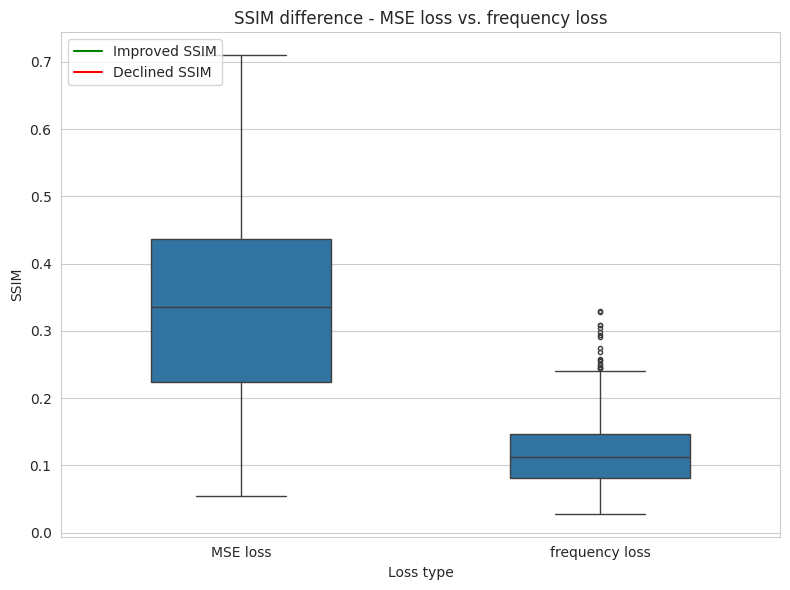

In [53]:
model1, _ = load_model_and_history(*data1)
model2, _ = load_model_and_history(*data2)
inx = 31


fig, ax = plt.subplots(2, 2, figsize=(10, 10))
classify_image(model1, test_input[inx], test_gt[inx], output='image')

inp = cv2.imread(test_input[inx], cv2.IMREAD_COLOR).astype(np.float32) / 255.0
inp = cv2.cvtColor(inp, cv2.COLOR_BGR2RGB)

gt = cv2.imread(test_gt[inx], cv2.IMREAD_COLOR).astype(np.float32) / 255.0
gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)

m1_output = classify_image(model1, test_input[inx], test_gt[inx], output='image')
m2_output = classify_image(model2, test_input[inx], test_gt[inx], output='image')

def show_image(ax, img, title):
    ax.imshow(img)
    ax.set_title(title)
    ax.grid(False)
    ax.axis('off')

show_image(ax[0, 0], inp, 'Input')
show_image(ax[0, 1], gt, 'Ground truth')
show_image(ax[1, 0], m1_output, 'Autoencoder output - 1 stack')
show_image(ax[1, 1], m2_output, 'Autoencoder output - 2 stacks')

